<a href="https://colab.research.google.com/github/PadariyaDebo/CGAN-DCGAN-WGAN/blob/main/PATE_CTGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/kasra-hosseini/privgem.git

Cloning into 'privgem'...
remote: Enumerating objects: 572, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 572 (delta 23), reused 17 (delta 17), pack-reused 544
Receiving objects: 100% (572/572), 180.42 KiB | 3.11 MiB/s, done.
Resolving deltas: 100% (303/303), done.


In [2]:
!pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install PuLP
!pip install networkx
!pip install dython
!pip install dython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 14.2 MB 5.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.2 MB 8.9 MB/s 
     |████████████████████████████████| 944 kB 60.3 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
%cd /content/privgem
!pip install -v -e .

Streaming output truncated to the last 5000 lines.
  Skipping link: none of the wheel's tags (cp37-cp37m-macosx_10_9_x86_64) are compatible (run pip debug --verbose to show compatible tags): https://files.pythonhosted.org/packages/cb/4d/9df2841432757b45d5b9973d85c982d4984aa2baea7ff48a905baa5fc781/pandas-1.3.3-cp37-cp37m-macosx_10_9_x86_64.whl#sha256=37d63e78e87eb3791da7be4100a65da0383670c2b59e493d9e73098d7a879226 (from https://pypi.org/simple/pandas/) (requires-python:>=3.7.1)
  Skipping link: none of the wheel's tags (cp37-cp37m-manylinux2014_aarch64, cp37-cp37m-manylinux_2_17_aarch64) are compatible (run pip debug --verbose to show compatible tags): https://files.pythonhosted.org/packages/59/a1/204bb9e5d03392a8b6ed88bc9eb00d0b90355ec520437f9654adfa1b6db7/pandas-1.3.3-cp37-cp37m-manylinux_2_17_aarch64.manylinux2014_aarch64.whl#sha256=53e2fb11f86f6253bb1df26e3aeab3bf2e000aaa32a953ec394571bec5dc6fd6 (from https://pypi.org/simple/pandas/) (requires-python:>=3.7.1)
  Found link https://fi

In [1]:
!python -m ipykernel install --user --name privgem_py38 --display-name "Python (privgem_py38)"

Installed kernelspec privgem_py38 in /root/.local/share/jupyter/kernels/privgem_py38


In [2]:
# solve issue with autocomplete
%config Completer.use_jedi = False

%load_ext autoreload
%autoreload 2
%matplotlib inline

from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Config option `use_jedi` not recognized by `IPCompleter`.
  


In [3]:
import os
import pandas as pd
import sys

In [4]:
from ctgan import load_demo

data = load_demo()
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [5]:
discrete_columns = [
    'workclass',
    'education',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'native-country',
    'income']

In [6]:
from privgem import tabular_utils

path_save="./test_patectgan/orig_data/orig_data.csv"
path_train="./test_patectgan/orig_data/orig_train.csv"
path_test="./test_patectgan/orig_data/orig_test.csv"

tabular_utils.split_save_orig_data(data,
                                   path_save=path_save,
                                   path_train=path_train,
                                   path_test=path_test,
                                   label_col="income",
                                   test_size=0.25,
                                   random_state=42)

[INFO] save the original file: /content/test_patectgan/orig_data/orig_data.csv
[INFO] split dataset
[INFO] save the train set: ./test_patectgan/orig_data/orig_train.csv
[INFO] save the test set: ./test_patectgan/orig_data/orig_test.csv


In [7]:
from privgem import tabular_patectgan

# inputs
epsilon = 2
batch_size = 64
noise_multiplier = 0.002
moments_order = 1000
output_save_path = "./test_patectgan/patectgan_training.csv"
device = "default" # or "default" or "cpu" or "cuda:1"

pate_model = tabular_patectgan(verbose=True, 
                               epsilon=epsilon, 
                               batch_size=batch_size, 
                               noise_multiplier=noise_multiplier, 
                               moments_order=moments_order, 
                               output_save_path=output_save_path,
                               device=device)

In [8]:
pate_model.train(data, discrete_columns)

using loss cross_entropy and regularization None
0 | 3.017528 | eps: 0.345915 (target: 2.000000) | G: 7.8474 | D: 2.4648 | Acc (fake): 0.9545 | Acc (true): 0.9165 | Acc (generator): 0.0000 | Acc (student): 0.4594
1 | 6.041714 | eps: 0.490716 (target: 2.000000) | G: 10.7265 | D: 4.6262 | Acc (fake): 0.9845 | Acc (true): 0.9866 | Acc (generator): 0.0156 | Acc (student): 0.5281
2 | 9.049616 | eps: 0.602403 (target: 2.000000) | G: 10.7137 | D: 5.0892 | Acc (fake): 0.9884 | Acc (true): 0.9891 | Acc (generator): 0.0312 | Acc (student): 0.5281
3 | 12.196659 | eps: 0.697015 (target: 2.000000) | G: 10.5639 | D: 5.4172 | Acc (fake): 0.9826 | Acc (true): 0.9848 | Acc (generator): 0.0469 | Acc (student): 0.4938
4 | 16.026669 | eps: 0.780564 (target: 2.000000) | G: 11.8363 | D: 5.4747 | Acc (fake): 0.9816 | Acc (true): 0.9854 | Acc (generator): 0.0156 | Acc (student): 0.4875
5 | 18.976039 | eps: 0.856485 (target: 2.000000) | G: 10.8343 | D: 4.2563 | Acc (fake): 0.9831 | Acc (true): 0.9838 | Acc (ge

---
PATE-CTGAN
 epsilon: 2, noise_multiplier: 0.002, moments order: 1000, batch_size: 64
max iter: 31, eps: 2.024371
---


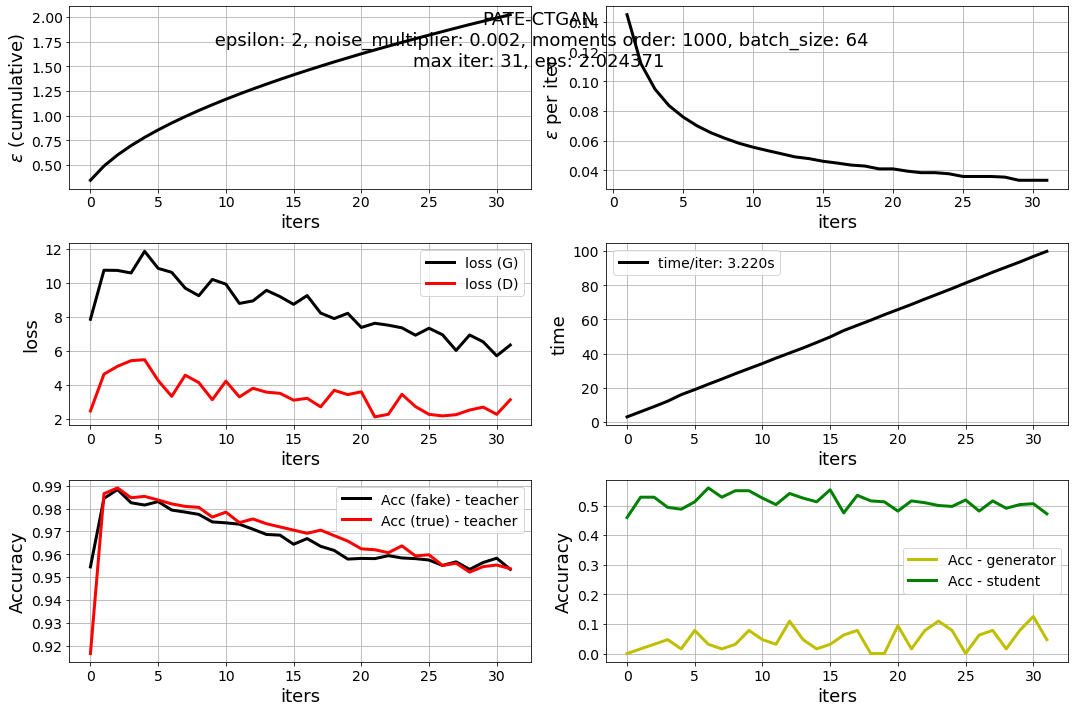

In [9]:
from privgem import tabular_utils

tabular_utils.plot_log_patectgan(filename="./test_patectgan/patectgan_training.csv")

In [10]:
synth_output = pate_model.sample(len(data))

path2synth_file = "./test_patectgan/patectgan_001/synthetic_output.csv"
os.makedirs(os.path.dirname(path2synth_file), exist_ok=True)
synth_output.to_csv(path2synth_file, index=False)

synth_output

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,60,Federal-gov,162147,5th-6th,9,Divorced,Other-service,Not-in-family,White,Female,20,3,29,Honduras,<=50K
1,44,Self-emp-not-inc,235742,HS-grad,7,Never-married,Prof-specialty,Other-relative,Black,Male,-88,-2,51,Thailand,<=50K
2,45,Private,699584,Doctorate,5,Divorced,?,Husband,Amer-Indian-Eskimo,Female,2,3,49,United-States,>50K
3,44,Self-emp-not-inc,313865,5th-6th,9,Married-civ-spouse,Craft-repair,Husband,White,Female,-77,3,45,El-Salvador,>50K
4,55,Self-emp-inc,140084,Masters,5,Married-civ-spouse,Prof-specialty,Own-child,Asian-Pac-Islander,Male,-7,2,40,Scotland,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,65,Federal-gov,202190,HS-grad,7,Married-civ-spouse,?,Husband,White,Male,-7,2,38,Germany,<=50K
32557,85,Self-emp-not-inc,376801,Preschool,13,Never-married,Exec-managerial,Not-in-family,White,Male,6267,-2,29,England,<=50K
32558,33,Federal-gov,375723,Bachelors,8,Married-civ-spouse,?,Not-in-family,White,Female,13832,-2,32,China,>50K
32559,40,Self-emp-inc,182696,1st-4th,9,Married-civ-spouse,Sales,Husband,White,Female,2509,0,14,South,<=50K
